# HOMEWORK 5: TEXT CLASSIFICATION
## Pakapon Leelakahakit 63340500045
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming) 

In this homework, you are asked to do the following tasks:
1. Data Cleaning
2. Preprocessing data for keras
3. Build and evaluate a model for "action" classification
4. Build and evaluate a model for "object" classification
5. Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 


Note: we have removed phone numbers from the dataset for privacy purposes. 

In [97]:
# from google.colab import drive
# drive.mount('/content/drive')

In [98]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/clean-phone-data.csv", "/content/clean-phone-data.csv")

## Import Libs

In [99]:
# %matplotlib inline
import pandas
import sklearn
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [100]:
data_df = pandas.read_csv('clean-phone-data.csv')

Let's preview the data.

In [101]:
# Show the top 5 rows
display(data_df.head())
# Summarize the data
data_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 1: 
You will have to remove unwanted label duplications as well as duplications in text inputs. 
Also, you will have to trim out unwanted whitespaces from the text inputs. 
This shouldn't be too hard, as you have already seen it in the demo.



In [102]:
display(data_df.describe())
display(data_df.Object.unique())
display(data_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

In [103]:
#TODO 1: Data cleaning

# ตั้งชื่อ Column 
data_df.columns = ['input', 'Action_label', 'Object_label']

# เปลี่ยน label ให้เป็นตัวพิมพ์เล็กให้หมด
data_df['Action_label'] = data_df['Action_label'].str.lower()
data_df['Object_label'] = data_df['Object_label'].str.lower()

# ลบช่องว่างข้างหน้าและหลังของประโยค
data_df['Action_label'] = data_df['Action_label'].str.strip()
data_df['Object_label'] = data_df['Object_label'].str.strip()

display(data_df.describe())
display(data_df.Action_label.unique())
display(data_df.Object_label.unique())

,input,Action_label,Object_label
count,16175,16175,16175
unique,13389,8,26
top,บริการอื่นๆ,enquire,service
freq,97,10484,2528


array(['enquire', 'report', 'cancel', 'buy', 'activate', 'request',
       'garbage', 'change'], dtype=object)

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

In [104]:
# ลบข้อความที่ซ้ำกันออกเหลือไม่เพียงตัวแรกสุดที่เจอตัวเดียว
data_df = data_df.drop_duplicates("input", keep="first")
display(np.shape(data_df),data_df.describe())

(13389, 3)

,input,Action_label,Object_label
count,13389,13389,13389
unique,13389,8,26
top,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,service
freq,1,8658,2111


In [105]:
display(data_df['input'])

0         <PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...
1                     internet ยังความเร็วอยุ่เท่าไหร ครับ
2         ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...
3         พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...
4         ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...
                               ...                        
16167                           ต้องการทราบวันตัดรอบบิลค่ะ
16170                       เชื่อมต่ออินเตอร์เน็ตไม่ได้ค่ะ
16172                              ยอดเงินเหลือเท่าไหร่ค่ะ
16173                                        ยอดเงินในระบบ
16174                 สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ
Name: input, Length: 13389, dtype: object

In [106]:
# ลบช่องว่างในการข้างหน้าและหลังข้างความ
data_df['input'] = data_df['input'].str.strip()
display(data_df['input'])

0        <PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter...
1                     internet ยังความเร็วอยุ่เท่าไหร ครับ
2        ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3        พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4        ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...
                               ...                        
16167                           ต้องการทราบวันตัดรอบบิลค่ะ
16170                       เชื่อมต่ออินเตอร์เน็ตไม่ได้ค่ะ
16172                              ยอดเงินเหลือเท่าไหร่ค่ะ
16173                                        ยอดเงินในระบบ
16174                 สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ
Name: input, Length: 13389, dtype: object

In [107]:
data_df['input'] = data_df['input'].str.replace("<PHONE_NUMBER_REMOVED>", "PhoneNumber")
data_df['input'] = data_df['input'].str.replace(" ", "")
display(data_df['input'])

0        PhoneNumberผมไปจ่ายเงินที่CounterServicesเค้าเ...
1                       internetยังความเร็วอยุ่เท่าไหรครับ
2          ตะกี้ไปชำระค่าบริการไปแล้วแต่ยังใช้งานไม่ได้ค่ะ
3         พี่ค่ะยังใช้internetไม่ได้เลยค่ะเป็นเครื่องโกลไล
4        ฮาโหลคะพอดีว่าเมื่อวานเปิดซิมทรูมูฟแต่มันโทรออ...
                               ...                        
16167                           ต้องการทราบวันตัดรอบบิลค่ะ
16170                       เชื่อมต่ออินเตอร์เน็ตไม่ได้ค่ะ
16172                              ยอดเงินเหลือเท่าไหร่ค่ะ
16173                                        ยอดเงินในระบบ
16174                 สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ
Name: input, Length: 13389, dtype: object

In [108]:
# Separate the "enquire" instances
enquire_df = data_df[data_df['Action_label'] == 'enquire']

# Set the number of "enquire" instances to keep
num_to_keep = 2000

# If the number of "enquire" instances is greater than the number to keep
if len(enquire_df) > num_to_keep:
    # Randomly select a subset of "enquire" instances to keep
    keep_indices = np.random.choice(enquire_df.index, num_to_keep, replace=False)
    keep_df = enquire_df.loc[keep_indices]
    
    # Combine the subset of "enquire" instances with the other instances
    data_df = pandas.concat([keep_df, data_df[data_df['Action_label'] != 'enquire']])

## #TODO 2: Preprocessing data for Keras
You will be using Tensorflow 2 keras in this assignment. Please show us how you prepare your data for keras.
Don't forget to split data into train and test sets (+ validation set if you want)

,label,count
0,enquire,2000
1,report,1442
2,cancel,1097
3,buy,784
4,activate,552
5,change,524
6,request,283
7,garbage,49


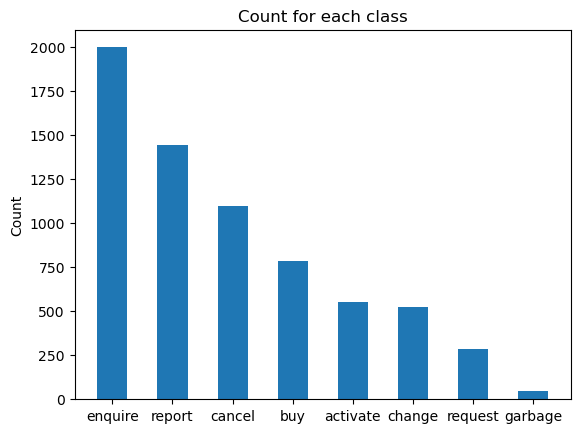

,label,count
0,service,1726
1,package,1337
2,suspend,650
3,phone_issues,581
4,internet,402
5,balance,339
6,information,278
7,promotion,264
8,lost_stolen,231
9,detail,159


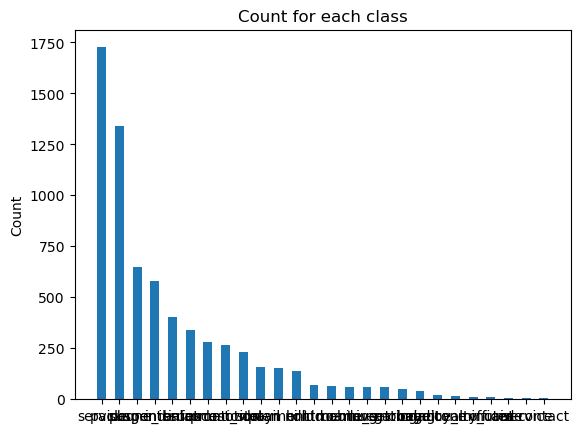

In [109]:
#TODO 2: Preprocessing data for Keras
def plot(label, count):
    fig, ax = plt.subplots()
    ind = np.arange(len(count))
    rects1 = ax.bar(ind, count, 0.5)

    ax.set_ylabel('Count')
    ax.set_title('Count for each class')
    ax.set_xticks(ind)
    ax.set_xticklabels(label)

    plt.show()

#-------------------------------------------------------------

label, count = np.unique(data_df.iloc[:, 1], return_counts=True)
# pack the label and count together
bundle = list(zip(label, count))
# sort them by count
bundle = sorted(bundle, key=lambda e: e[1], reverse=True) 
# unpack the values
label, count = zip(*bundle)
display(pandas.DataFrame({'label': label, 'count': count}))
plot(label, count)
#-------------------------------------------------------------

label, count = np.unique(data_df.iloc[:, 2], return_counts=True)
# pack the label and count together
bundle = list(zip(label, count))
# sort them by count
bundle = sorted(bundle, key=lambda e: e[1], reverse=True) 
# unpack the values
label, count = zip(*bundle)
display(pandas.DataFrame({'label': label, 'count': count}))
plot(label, count)

In [110]:
data = data_df.to_numpy()
action_label = data_df['Action_label'].unique()

action_label_to_num_map = dict(zip(action_label, range(len(action_label))))
num_to_action_label_map = dict(zip(range(len(action_label)), action_label))

print("Create Mappings")
display(num_to_action_label_map)
display(action_label_to_num_map)

print("Before Mappings")
display(data[:, 1])
data[:,1] = np.vectorize(action_label_to_num_map.get)(data[:,1])

print("After Mappings")
display(data[:, 1])

Create Mappings


{0: 'enquire',
 1: 'report',
 2: 'cancel',
 3: 'buy',
 4: 'activate',
 5: 'request',
 6: 'garbage',
 7: 'change'}

{'enquire': 0,
 'report': 1,
 'cancel': 2,
 'buy': 3,
 'activate': 4,
 'request': 5,
 'garbage': 6,
 'change': 7}

Before Mappings


array(['enquire', 'enquire', 'enquire', ..., 'change', 'activate',
       'activate'], dtype=object)

After Mappings


array([0, 0, 0, ..., 7, 4, 4], dtype=object)

In [111]:
object_label = data_df['Object_label'].unique()

object_label_to_num_map = dict(zip(object_label, range(len(object_label))))
num_to_object_label_map = dict(zip(range(len(object_label)), object_label))

print("Create Mappings")
display(num_to_object_label_map)
display(object_label_to_num_map)

print("Before Mappings")
display(data[:, 2])
data[:,2] = np.vectorize(object_label_to_num_map.get)(data[:,2])

print("After Mappings")
display(data[:, 2])

Create Mappings


{0: 'internet',
 1: 'bill',
 2: 'balance',
 3: 'truemoney',
 4: 'package',
 5: 'detail',
 6: 'promotion',
 7: 'roaming',
 8: 'ringtone',
 9: 'credit',
 10: 'suspend',
 11: 'payment',
 12: 'mobile_setting',
 13: 'service',
 14: 'nontruemove',
 15: 'idd',
 16: 'iservice',
 17: 'rate',
 18: 'balance_minutes',
 19: 'loyalty_card',
 20: 'information',
 21: 'phone_issues',
 22: 'lost_stolen',
 23: 'garbage',
 24: 'contact',
 25: 'officer'}

{'internet': 0,
 'bill': 1,
 'balance': 2,
 'truemoney': 3,
 'package': 4,
 'detail': 5,
 'promotion': 6,
 'roaming': 7,
 'ringtone': 8,
 'credit': 9,
 'suspend': 10,
 'payment': 11,
 'mobile_setting': 12,
 'service': 13,
 'nontruemove': 14,
 'idd': 15,
 'iservice': 16,
 'rate': 17,
 'balance_minutes': 18,
 'loyalty_card': 19,
 'information': 20,
 'phone_issues': 21,
 'lost_stolen': 22,
 'garbage': 23,
 'contact': 24,
 'officer': 25}

Before Mappings


array(['internet', 'bill', 'internet', ..., 'package', 'service',
       'service'], dtype=object)

After Mappings


array([0, 1, 0, ..., 4, 13, 13], dtype=object)

In [112]:
# # Split the data into training and testing sets
# from sklearn.model_selection import train_test_split
# X_train_1, X_test_1, y_train_action, y_test_action, y_train_object, y_test_object = train_test_split(input_tokenize, action_label_onehot, object_label_onehot, test_size=0.2, random_state=42)

In [113]:
from pythainlp.tokenize import word_tokenize

input_tokenize = data.copy()
for i, sentence in enumerate(input_tokenize[:, 0]):
    input_tokenize[i, 0] = word_tokenize(sentence, engine='newmm')
    
display(input_tokenize[0,0])

['พอดี',
 'จะ',
 'ถาม',
 'ว่า',
 'เบอร์',
 'นี้',
 'เปิด',
 'ใช้',
 'Internet',
 'ได้',
 'หรือเปล่า',
 'ค่ะ']

In [114]:
from collections import Counter

word_counts = Counter()
for sentence in input_tokenize[:,0]:
    word_counts.update(sentence)
    
display(word_counts.most_common(100))

[('ค่ะ', 3143),
 ('จะ', 2751),
 ('ครับ', 2386),
 ('ได้', 1560),
 ('ไม่', 1529),
 ('ผม', 1185),
 ('สอบถาม', 1128),
 ('ว่า', 1036),
 ('ยกเลิก', 1021),
 ('ไป', 1007),
 ('เบอร์', 1001),
 ('โทร', 977),
 ('แล้ว', 973),
 ('อยาก', 967),
 ('สมัคร', 916),
 ('มัน', 860),
 ('ที่', 841),
 ('เปิด', 822),
 ('คะ', 807),
 ('ใช้', 788),
 ('พอดี', 770),
 ('มา', 769),
 ('ให้', 744),
 ('สัญญาณ', 732),
 ('ขอ', 709),
 ('อ่ะ', 706),
 ('พี่', 669),
 ('มี', 581),
 ('ต้องการ', 569),
 ('เปลี่ยน', 555),
 ('ของ', 546),
 ('โทรศัพท์', 527),
 ('หน่อย', 522),
 ('อินเตอร์เน็ต', 518),
 ('โปรโมชั่น', 516),
 ('ซิม', 489),
 ('นี้', 483),
 ('เลย', 467),
 ('คือ', 460),
 ('บริการ', 430),
 ('ต้อง', 421),
 ('เป็น', 413),
 ('ระงับ', 406),
 ('ยัง', 398),
 ('ข้อความ', 378),
 ('โปร', 372),
 ('ใช้งาน', 369),
 ('ทรูมูฟ', 364),
 ('เงิน', 361),
 ('อะไร', 360),
 ('แต่', 356),
 ('ทราบ', 339),
 ('ค่าบริการ', 336),
 ('เรื่อง', 333),
 ('เติม', 331),
 ('ชำระ', 322),
 ('โดน', 315),
 ('การ', 312),
 ('ตอนนี้', 309),
 ('เครื่อง', 308),
 ('จ่าย', 

In [115]:
data_df['input'] = data_df['input'].str.replace(("(ค่ะ|จะ|ครับ|ผม|คะ|อ่ะ|พี่|เรา|เค้า)"), "")
display(data_df['input'])

d:\Programs\Anaconda3\envs\tensorflow_09_04_66_2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


8895     พอดีถามว่าเบอร์นี้เปิดใช้Internetได้หรือเปล่า
8527                    อยากทราบวันครบกำหนดรอบเดือนของ
3704           คือสอบถามตอนนี้Wifiใช้งานได้แล้วใช่มั้ย
11081    สวัสดีพอดีอยากสอบถามค่าโทรของเบอร์PhoneNumber
3326      รอรหัสทรูมันนี่ที่ว่า4หลักยังไม่เห็นส่งมาเลย
                             ...                      
16139                 ต้องการสมัครแพคเกจสมัครโปรโมชั่น
16152                                    มือถือถูกขโมย
16154              ต้องการเปลี่ยนโปรโมชั่นอินเตอร์เน็ต
16157                         เปิดใช้งานอินเตอร์เน็ตอะ
16162                               เปิดบริการครั้งแรก
Name: input, Length: 6731, dtype: object

In [116]:
data[:,0] = data_df['input'].to_numpy()
input_tokenize = data.copy()
for i, sentence in enumerate(input_tokenize[:, 0]):
    input_tokenize[i, 0] = word_tokenize(sentence, engine='newmm')
    
display(input_tokenize[0,0])

['พอดี',
 'ถาม',
 'ว่า',
 'เบอร์',
 'นี้',
 'เปิด',
 'ใช้',
 'Internet',
 'ได้',
 'หรือเปล่า']

In [117]:
word_counts = Counter()
for sentence in input_tokenize[:,0]:
    word_counts.update(sentence)
    
display(word_counts.most_common(100))

[('ได้', 1550),
 ('ไม่', 1526),
 ('สอบถาม', 1128),
 ('ว่า', 1037),
 ('ยกเลิก', 1021),
 ('แล้ว', 1007),
 ('เบอร์', 1001),
 ('ไป', 998),
 ('โทร', 977),
 ('อยาก', 959),
 ('สมัคร', 915),
 ('มัน', 860),
 ('ที่', 858),
 ('เปิด', 821),
 ('ใช้', 786),
 ('พอดี', 770),
 ('มา', 766),
 ('ให้', 743),
 ('สัญญาณ', 732),
 ('ขอ', 707),
 ('มี', 581),
 ('ต้องการ', 569),
 ('เปลี่ยน', 555),
 ('ของ', 544),
 ('โทรศัพท์', 527),
 ('หน่อย', 522),
 ('อินเตอร์เน็ต', 518),
 ('โปรโมชั่น', 516),
 ('ซิม', 489),
 ('นี้', 483),
 ('เลย', 467),
 ('คือ', 460),
 ('บริการ', 430),
 ('ต้อง', 421),
 ('เป็น', 414),
 ('ระงับ', 406),
 ('ยัง', 397),
 ('ข้อความ', 376),
 ('โปร', 372),
 ('ใช้งาน', 369),
 ('แจ้ง', 365),
 ('ทรูมูฟ', 364),
 ('อะไร', 363),
 ('เงิน', 360),
 ('แต่', 342),
 ('ทราบ', 339),
 ('ค่าบริการ', 336),
 ('เรื่อง', 333),
 ('เติม', 331),
 ('ชำระ', 322),
 ('โดน', 315),
 ('การ', 312),
 ('ตอนนี้', 309),
 ('เครื่อง', 308),
 ('จ่าย', 305),
 ('ตัด', 304),
 ('อยู่', 301),
 ('ออก', 298),
 ('เน็ต', 285),
 ('นะ', 282),
 ('ทรู', 

In [118]:
display(data)

array([['พอดีถามว่าเบอร์นี้เปิดใช้Internetได้หรือเปล่า', 0, 0],
       ['อยากทราบวันครบกำหนดรอบเดือนของ', 0, 1],
       ['คือสอบถามตอนนี้Wifiใช้งานได้แล้วใช่มั้ย', 0, 0],
       ...,
       ['ต้องการเปลี่ยนโปรโมชั่นอินเตอร์เน็ต', 7, 4],
       ['เปิดใช้งานอินเตอร์เน็ตอะ', 4, 13],
       ['เปิดบริการครั้งแรก', 4, 13]], dtype=object)

In [119]:
display(data[4, 0])
display(data[:, 1])

'รอรหัสทรูมันนี่ที่ว่า4หลักยังไม่เห็นส่งมาเลย'

array([0, 0, 0, ..., 7, 4, 4], dtype=object)

In [120]:
action_keywords = []
used_words = set()

for i in range(1, 8):  # exclude class 0
    
    counts_word = []

    mask = data[:, 1] == i
    sentence_action = data[mask, 0]

    for j, sentence in enumerate(sentence_action):
        sentence_action[j] = word_tokenize(sentence, engine='newmm')
        counts_word.extend(sentence_action[j])
            
    word_counts_action = Counter(counts_word)

    top_keywords = []
    for word, count in word_counts_action.most_common(15):
        if word not in used_words:
            top_keywords.append(word)

    action_keywords.append(top_keywords)
    # used_words.update(top_keywords)
    print(f"Class {i}: {top_keywords}")

Class 1: ['ไม่', 'ได้', 'โทร', 'ไป', 'แล้ว', 'โทรศัพท์', 'เบอร์', 'มัน', 'ว่า', 'ระงับ', 'สัญญาณ', 'พอดี', 'โดน', 'ซิม', 'ออก']
Class 2: ['ยกเลิก', 'ข้อความ', 'ที่', 'อยาก', 'ขอ', 'ต้องการ', 'เบอร์', 'SMS', 'บริการ', 'มา', 'สาย', 'ให้', 'รอ', 'โทร', 'นี้']
Class 3: ['สมัคร', 'อินเตอร์เน็ต', 'ต้องการ', 'โปร', 'อยาก', 'เน็ต', 'บาท', 'แพคเกจ', 'ได้', 'บี', 'ซื้อ', 'ต้อง', 'รายวัน', 'ไม่', 'วัน']
Class 4: ['เปิด', 'สัญญาณ', 'ให้', 'ขอ', 'แล้ว', 'ไป', 'หน่อย', 'มา', 'บริการ', 'ใช้', 'พอดี', 'โทร', 'ชำระ', 'ได้', 'จ่าย']
Class 5: ['สอบถาม', 'ที่', 'เครื่อง', 'ว่า', 'มี', 'ช็อป', 'ไม่', 'ไป', 'ได้', 'ทราบ', 'ทรู', 'อยาก', 'เบอร์', 'ของ', 'ซื้อ']
Class 6: ['เบอร์', 'มา', 'โทร', 'อะไร', 'ว่า', 'แล้ว', 'ไม่', 'ที่', 'สอบถาม', 'คือ', 'มัน', 'หนู', 'มี', 'ได้', 'เมื่อกี้']
Class 7: ['เปลี่ยน', 'โปรโมชั่น', 'อยาก', 'โปร', 'ได้', 'ต้องการ', 'ขอ', 'เป็น', 'ที่อยู่', 'ว่า', 'ใช้', 'สอบถาม', 'แจ้ง', 'พอดี', 'เบอร์']


In [121]:
action_keywords = []
action_keywords = ['เปลี่ยน', 'โปรโมชั่น', 'เป็น', 'ที่อยู่', 'แจ้ง','อะไร', 'คือ', 'หนู', 'เมื่อกี้', 'สอบถาม', 'เครื่อง', 'มี', 
'ช็อป', 'ทราบ', 'ทรู', 'ของ', 'เปิด', 'หน่อย', 'ใช้', 'ชำระ', 'จ่าย','สมัคร', 'อินเตอร์เน็ต', 'โปร', 'เน็ต', 'บาท', 'แพคเกจ', 
'บี', 'ซื้อ', 'ต้อง', 'รายวัน', 'วัน','ยกเลิก', 'ข้อความ', 'ที่', 'อยาก', 'ขอ', 'ต้องการ', 'SMS', 'บริการ', 'มา', 'สาย', 'ให้', 
'รอ', 'นี้', 'โทรศัพท์', 'ระงับ','โดน','ซิม','ออก']
len(action_keywords)

50

In [122]:
object_keywords = []
used_words = set()

for i in range(26):  # exclude class 0
    
    counts_word = []

    mask = data[:, 2] == i
    sentence_object = data[mask, 0]

    for j, sentence in enumerate(sentence_object):
        sentence_object[j] = word_tokenize(sentence, engine='newmm')
        counts_word.extend(sentence_object[j])
            
    word_counts_object = Counter(counts_word)

    top_keywords = []
    for word, count in word_counts_object.most_common(15):
        if word not in used_words:
            top_keywords.append(word)

    object_keywords.append(top_keywords)
    # used_words.update(top_keywords)
    print(f"Class {i}: {top_keywords}")

Class 0: ['ไม่', 'ได้', 'อินเตอร์เน็ต', 'มัน', 'สอบถาม', 'แล้ว', 'ใช้', 'ใช้งาน', 'ว่า', 'เน็ต', 'เล่น', 'สมัคร', 'เปิด', 'อยาก', 'ไวไฟ']
Class 1: ['บิล', 'มี', 'สอบถาม', 'ไม่', 'มา', 'ว่า', 'ค่าบริการ', 'ได้', 'อยาก', 'แล้ว', 'ใบ', 'แจ้ง', 'ใช้', 'รอบ', 'มัน']
Class 2: ['สอบถาม', 'ยอด', 'อยาก', 'ว่า', 'ค่าบริการ', 'ใช้', 'เบอร์', 'ค่า', 'ที่', 'เท่าไหร่', 'ของ', 'นี้', 'เช็ค', 'มี', 'ทราบ']
Class 3: ['มัน', 'ทรู', 'นี่', 'เติม', 'เงิน', 'ได้', 'ไม่', 'เข้า', 'ว่า', 'บัตร', 'แล้ว', 'สอบถาม', 'ผิด', 'คือ', 'กด']
Class 4: ['สมัคร', 'เปลี่ยน', 'โปรโมชั่น', 'โปร', 'อยาก', 'อินเตอร์เน็ต', 'ต้องการ', 'ได้', 'สอบถาม', 'ใช้', 'ว่า', 'เน็ต', 'ไม่', 'ที่', 'เบอร์']
Class 5: ['เปลี่ยน', 'ที่อยู่', 'เบอร์', 'ว่า', 'แจ้ง', 'สอบถาม', 'ใช้', 'ได้', 'อยาก', 'ใน', 'ที่', 'ขอ', 'มา', 'การ', 'ต้อง']
Class 6: ['สอบถาม', 'โปรโมชั่น', 'อยาก', 'โปร', 'ที่', 'มี', 'อะไร', 'ของ', 'โทร', 'อินเตอร์เน็ต', 'เรื่อง', 'ได้', 'สมัคร', 'ทรูมูฟ', 'บ้าง']
Class 7: ['โรม', 'ไป', 'ต่างประเทศ', 'มิ่ง', 'สอบถาม', 'เปิด', 'ใ

In [123]:
object_keywords = []
object_keywords = ['เจ้าหน้าที่', '1331', 'ร้องเรียน', 'พนักงาน', 'หาไม่', 'ทำไม', 'ลูกค้า',
'ได้รับ', 'การใช้งาน', 'หา', 'เตือน', 'เรือง', 'เอสเอ็มเอส', 'เตื่อน','การ์ด', 'แบร็ค', 'เร', 'ด', 'สิทธิ์', 'ส่วนลด', 'เรื่อง', 'หน่อย',
'คิด', 'ทรูมูฟ', 'เอช', 'รอ', 'สาย', 'เพลง', 'เสียงเพลง', 'โหลด', 'เสียง', 'เปลี่ยนเสียง','คือ', 'หนู', 'เมื่อกี้'
'ดี','นาที', 'กี่', 'คงเหลือ', 'เหลือ','หาย', 'ทำ', 'มือถือ','ช็อป', 'ทราบ' ,'นี่', 'บัตร', 'ซื้อ', 'ผิด','โรม', 'มิ่ง', 'ต่างประเทศ', 'ดา', 'ต้า'
'TrueIservice', 'ใส่','ตั้งค่า', 'การ', 'เครื่อง', 'ต้อง', 'โอน','อะไร', 'บ้าง', 'บี', 'วงเงิน', 'เพิ่ม', 'บิล', 'แจ้ง','ที่อยู่', 'เป็น','ยอด', 'นี้', 'ค่า', 'เช็ค', 'เท่าไหร่',
'ทรู', 'มี', 'กล่อง','ยกเลิก', 'ขอ', 'ให้', 'ข้อความ', 'บริการ','ออก', 'ซิม', 'เลย','เน็ต', 'เล่น', 'ใช้งาน', 'ไวไฟ', 'เปิด','ระงับ', 'โดน', 'ถูก', 'ตัด', 'สัญญาณ', 'โทร', 'โทรศัพท์',
'สมัคร', 'โปรโมชั่น', 'เปลี่ยน', 'โปร', 'อยาก', 'ใช้', 'ที่', 'อินเตอร์เน็ต', 'เบอร์', 'ต้องการ', 'ของ','เติม','ชำระ', 'จ่าย', 'เข้า']
len(object_keywords)

111

In [124]:
def has_keyword_action(string):
    global action_keywords
    result = np.zeros(len(action_keywords))
    for index, keyword in enumerate(action_keywords):
        if keyword in string:
            result[index] = 1
    return result
    
def has_keyword_object(string):
    global object_keywords
    result = np.zeros(len(object_keywords))
    for index, keyword in enumerate(object_keywords):
        if keyword in string:
            result[index] = 1
    return result

In [125]:
temp_action = np.vectorize(has_keyword_action, otypes=[object])(data[:, 0])
x_f2_action = np.array([[e for e in sl] for sl in temp_action.tolist()])
label_action = data[:, 1].astype(int)
print("Data")
print("Data shape", x_f2_action.shape)
print("label shape", label_action.shape)
display(x_f2_action)
display(label_action)

Data
Data shape (6731, 50)
label shape (6731,)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([0, 0, 0, ..., 7, 4, 4])

In [126]:
temp_object = np.vectorize(has_keyword_object, otypes=[object])(data[:, 0])
print(temp_object[0:4])
x_f2_object = np.array([[e for e in sl] for sl in temp_object.tolist()])
label_object = data[:, 2].astype(int)
print("Data")
print("Data shape", x_f2_object.shape)
print("label shape", label_object.shape)
display(x_f2_object)
display(x_f2_object.shape)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0.]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(6731, 111)

In [127]:
print(label_action, label_action.min(), label_action.max())
print(label_object, label_object.min(), label_object.max())

[0 0 0 ... 7 4 4] 0 7
[ 0  1  0 ...  4 13 13] 0 25


In [128]:
from sklearn.preprocessing import OneHotEncoder

enc_action = OneHotEncoder(categories='auto')
enc_object = OneHotEncoder(categories='auto')
enc_action.fit(label_action.reshape(-1, 1))
enc_object.fit(label_object.reshape(-1, 1))
onehot_action = enc_action.transform(label_action.reshape(-1, 1)).toarray()
onehot_object = enc_object.transform(label_object.reshape(-1, 1)).toarray()
print(onehot_action,onehot_action.shape)
print(onehot_object,onehot_object.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (6731, 8)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (6731, 26)


In [129]:
from sklearn.model_selection import train_test_split
x_train_action, x_test_action, y_train_action, y_test_action, x_train_object, x_test_object, y_train_object, y_test_object = train_test_split(x_f2_action, onehot_action, x_f2_object, onehot_object, test_size=0.2, random_state=42)

In [130]:
print(x_f2_action[4])
print(x_f2_action.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0.]
(6731, 50)


## #TODO 3: Build and evaluate a model for "action" classification


In [131]:
#TODO 3: Build and evaluate a model for "action" classification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

num_classes_action = len(data_df['Action_label'].unique())

model_action = Sequential()
model_action.add(Dense(units=128, activation='relu', input_shape=(50,)))
model_action.add(Dropout(0.5)) 
model_action.add(Dense(units=64, activation='relu'))
model_action.add(Dropout(0.5)) 
model_action.add(Dense(num_classes_action, activation='softmax'))

model_action.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_action.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               6528      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
Total params: 15,304
Trainable params: 15,304
Non-trainable params: 0
_________________________________________________________________


In [132]:
history = model_action.fit(x_train_action, y_train_action, epochs=50, batch_size=64, validation_split=0.2)
score = model_action.evaluate(x_test_action, y_test_action, verbose=0)

print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Epoch 1/50
68/68 [==============================] - 5s 20ms/step - loss: 1.8302 - accuracy: 0.3350 - val_loss: 1.4771 - val_accuracy: 0.5636
Epoch 2/50
68/68 [==============================] - 1s 8ms/step - loss: 1.3790 - accuracy: 0.5417 - val_loss: 0.9875 - val_accuracy: 0.6908
Epoch 3/50
68/68 [==============================] - 1s 9ms/step - loss: 1.0990 - accuracy: 0.6494 - val_loss: 0.8235 - val_accuracy: 0.7252
Epoch 4/50
68/68 [==============================] - 1s 8ms/step - loss: 0.9782 - accuracy: 0.6912 - val_loss: 0.7759 - val_accuracy: 0.7363
Epoch 5/50
68/68 [==============================] - 1s 8ms/step - loss: 0.8950 - accuracy: 0.7153 - val_loss: 0.7531 - val_accuracy: 0.7382
Epoch 6/50
68/68 [==============================] - 1s 9ms/step - loss: 0.8872 - accuracy: 0.7207 - val_loss: 0.7373 - val_accuracy: 0.7512
Epoch 7/50
68/68 [==============================] - 1s 8ms/step - loss: 0.8450 - accuracy: 0.7337 - val_loss: 0.7261 - val_accuracy: 0.7521
Epoch 8/50
68/68 [=

In [136]:
# Save the model to a file
model_action.save('model_action.h5')

## #TODO 4: Build and evaluate a model for "object" classification

In [134]:
#TODO 4: Build and evaluate a model for "object" classification

num_classes_object = len(data_df['Object_label'].unique())

model_object = Sequential()
model_object.add(Dense(units=128, activation='relu', input_shape=(111,)))
model_object.add(Dropout(0.5)) 
model_object.add(Dense(units=64, activation='relu'))
model_object.add(Dropout(0.5)) 
model_object.add(Dense(num_classes_object, activation='softmax'))

model_object.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_object.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               14336     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 26)                1690      
                                                                 
Total params: 24,282
Trainable params: 24,282
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = model_object.fit(x_train_object, y_train_object, epochs=50, batch_size=32, validation_split=0.2)
score = model_object.evaluate(x_test_object, y_test_object, verbose=0)

print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Epoch 1/50
135/135 [==============================] - 7s 15ms/step - loss: 2.5114 - accuracy: 0.3141 - val_loss: 1.8498 - val_accuracy: 0.5218
Epoch 2/50
 36/135 [=======>......................] - ETA: 0s - loss: 1.9448 - accuracy: 0.4714

KeyboardInterrupt: 

## #TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 

This can be a bit tricky, if you are not familiar with the Keras functional API. PLEASE READ these webpages(https://www.tensorflow.org/guide/keras/functional, https://keras.io/getting-started/functional-api-guide/) before you start this task.   

Your model will have 2 separate output layers one for action classification task and another for object classification task. 

This is a rough sketch of what your model might look like:
image --> https://drive.google.com/file/d/1r7M6tFyQDu6pJIxLd_fn2kBMjo_CWmUK/view?usp=share_link

<center><img src="HW3-1_multitask_sketch.png" alt="Alternative text" /></center>

In [ ]:
#TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go

input_layer = Input(shape=(111,))
dense_layer_1 = Dense(units=128, activation='relu')(input_layer)
dropout_layer_1 = Dropout(0.5)(dense_layer_1)
dense_layer_2 = Dense(units=64, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.5)(dense_layer_2)
action_output = Dense(units=num_classes_action, activation='softmax', name='action')(dropout_layer_2)
object_output = Dense(units=num_classes_object, activation='softmax', name='object')(dropout_layer_2)
model = Model(inputs=input_layer, outputs=[action_output, object_output])
model.compile(loss={'action': 'categorical_crossentropy', 'object': 'categorical_crossentropy'}, optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 111)]        0           []                               
                                                                                                  
 dense_57 (Dense)               (None, 128)          14336       ['input_10[0][0]']               
                                                                                                  
 dropout_44 (Dropout)           (None, 128)          0           ['dense_57[0][0]']               
                                                                                                  
 dense_58 (Dense)               (None, 64)           8256        ['dropout_44[0][0]']             
                                                                                            

In [ ]:
history = model.fit(x_train_object, {'action': y_train_action, 'object': y_train_object},
epochs=50, batch_size=32, validation_split=0.2)

score = model.evaluate(x_test_object, {'action': y_test_action, 'object': y_test_object}, verbose=0)
print(f'Test loss: {score[0]}')
print(f'accuracy action: {score[1]}')
print(f'accuracy object: {score[2]}')

Epoch 1/50
268/268 [==============================] - 14s 18ms/step - loss: 3.7864 - action_loss: 1.1787 - object_loss: 2.6077 - action_accuracy: 0.6494 - object_accuracy: 0.2454 - val_loss: 2.6412 - val_action_loss: 0.7154 - val_object_loss: 1.9258 - val_action_accuracy: 0.7783 - val_object_accuracy: 0.4685
Epoch 2/50
268/268 [==============================] - 3s 11ms/step - loss: 2.7336 - action_loss: 0.7773 - object_loss: 1.9563 - action_accuracy: 0.7567 - object_accuracy: 0.4399 - val_loss: 2.1463 - val_action_loss: 0.5616 - val_object_loss: 1.5847 - val_action_accuracy: 0.8222 - val_object_accuracy: 0.5553
Epoch 3/50
268/268 [==============================] - 3s 12ms/step - loss: 2.4082 - action_loss: 0.6845 - object_loss: 1.7237 - action_accuracy: 0.7754 - object_accuracy: 0.5025 - val_loss: 1.9620 - val_action_loss: 0.5248 - val_object_loss: 1.4372 - val_action_accuracy: 0.8329 - val_object_accuracy: 0.5940
Epoch 4/50
268/268 [==============================] - 3s 12ms/step - los